In [1]:
# === Importation des bibliothèques nécessaires ===

# Utilitaires
import os
import math
import warnings
import random
from tqdm import tqdm

# NumPy et Pandas pour le traitement des données
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement du signal
from scipy import signal, interpolate
from scipy.io import loadmat
from scipy.signal import find_peaks, savgol_filter, resample, medfilt, butter, filtfilt
import pywt
from pywt import wavedec

# Utilitaires pour les fichiers
import wfdb
import tarfile
import h5py

# Scikit-learn pour le Machine Learning
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample as sklearn_resample
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_log_error, explained_variance_score, max_error

# TensorFlow et Keras pour les modèles de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import h5py
from scipy.io import loadmat
from scipy.signal import find_peaks
import warnings
from scipy.signal import butter, filtfilt

import numpy as np
import pandas as pd
from scipy.signal import welch

# tf.keras.backend.set_floatx('float16')

In [2]:
# Fonction pour charger les données ECG et le nom du patient
def load_challenge_data(filename):
    with open(filename, 'rb') as f:
        header = f.read(4)
        if header == b'MAT4':
            print(f"Fichier ignoré (format MATLAB 4) : {filename}")
            return None, None, None

    try:
        data = loadmat(filename)
        ecg_1 = np.asarray(data['ECG_1'], dtype=np.float64)
        ecg_2 = np.asarray(data['ECG_2'], dtype=np.float64)
        ecg_3 = np.asarray(data['ECG_3'], dtype=np.float64)
        pat_name = data['PatName'][0] if 'PatName' in data else 'Unknown'
        beatpos = np.asarray(data['beatpos'], dtype=np.float64)
    except (ValueError, NotImplementedError):
        try:
            with h5py.File(filename, 'r') as f:
                ecg_1 = np.array(f['ECG_1'])
                ecg_2 = np.array(f['ECG_2'])
                ecg_3 = np.array(f['ECG_3'])
                pat_name = f['PatName'][()].decode('utf-8') if 'PatName' in f else 'Unknown'
                beatpos = np.array(f['beatpos'])
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {filename} : {e}")
            return None, None, None

    if 'ecg_1' not in locals() or 'ecg_2' not in locals() or 'ecg_3' not in locals():
        print(f"Données ECG non présentes dans {filename}. Fichier ignoré.")
        return None, None, None

    # Redimensionner pour obtenir la même longueur dans chaque dérivation
    min_length = min(ecg_1.shape[1], ecg_2.shape[1], ecg_3.shape[1])
    ecg_1 = ecg_1[:, :min_length]
    ecg_2 = ecg_2[:, :min_length]
    ecg_3 = ecg_3[:, :min_length]
    data = np.vstack([ecg_1, ecg_2, ecg_3])

    return data, pat_name, beatpos

# Fonction pour obtenir la fréquence d'échantillonnage
def get_sampling_frequency(filename):
    with open(filename, 'rb') as f:
        header = f.read(4)
        if header == b'MAT4':
            print(f"Fichier ignoré (format MATLAB 4) : {filename}")
            return None

    try:
        x = loadmat(filename)
        return x['sampling_frequency'][0][0] if 'sampling_frequency' in x else 250
    except Exception as e:
        print(f"Erreur lors de la lecture de la fréquence d'échantillonnage : {e}")
        return None

def convert_seconds_to_hms(seconds):
    """Convert a duration in seconds to hours, minutes, and seconds."""
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

# Fonction principale pour charger et traiter un fichier ECG unique
def load_single_ecg(file_path):
    data, pat_name, beatpos = load_challenge_data(file_path)
    if data is None:
        return None, None, None

    sampling_rate = get_sampling_frequency(file_path)
    if sampling_rate is None:
        return None, None, None

    num_samples = data.shape[1]
    duration_seconds = convert_seconds_to_hms(num_samples / sampling_rate)

    # Conversion en millivolts
    ecg_data = data / 1000

    # Sauvegarde des caractéristiques dans un DataFrame
    df_characteristics = pd.DataFrame([{
        'Patient Name': pat_name,
        'Sampling Rate (Hz)': sampling_rate,
        'Duration (s)': duration_seconds,
        'Number of Samples': num_samples
    }])

    print("ECG complet chargé et converti.")
    return ecg_data, df_characteristics, beatpos

# Exemple d'utilisation
ecg_data, df_characteristics, beatpos = load_single_ecg("C:/Users/marwa/Downloads/archive/Fall_Mamadou.mat")
print(df_characteristics)
print(ecg_data.shape)

print(beatpos)


ECG complet chargé et converti.
   Patient Name  Sampling Rate (Hz)  Duration (s)  Number of Samples
0  Mamadou FALL                 250  (14, 22, 32)           12938072
(3, 12938072)
[[4.36000000e-01 1.12400000e+00 1.86800000e+00 ... 5.17497580e+04
  5.17506648e+04 5.17515170e+04]]


In [3]:
# Filtre notch pour supprimer l'interférence secteur (50Hz ou 60Hz)
def notch_filter(ecg_signal, freq=50, fs=250, quality_factor=30):
    b, a = signal.iirnotch(freq / (fs / 2), quality_factor)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

In [4]:
def moving_average_filter(ecg_signal, window_size=15):
    """
    Applique un filtre de moyenne mobile pour lisser le signal sans supprimer les pics R.
    """
    return np.convolve(ecg_signal, np.ones(window_size) / window_size, mode='same')


In [5]:
# Filtre passe-bande pour le signal ECG
def bandpass_filter(ecg_signal, lowcut=0.5, highcut=40.0, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

In [6]:
# Détection des pics R en utilisant Pan-Tompkins amélioré
def detect_r_peaks(ecg_signal, fs=250, distance=200, height_threshold=None):
    diff_signal = np.diff(bandpass_filter(ecg_signal, fs=fs))
    squared_signal = diff_signal ** 2
    smoothed_signal = moving_average_filter(squared_signal, window_size=int(0.150 * fs))
    peaks, _ = find_peaks(smoothed_signal, distance=distance, height=height_threshold)
    return peaks

# Correction des artefacts avec interpolation autour des pics R anormaux
def correct_artifacts(ecg_signal, peaks, fs=250):
    rr_intervals = np.diff(peaks) / fs
    median_rr = np.median(rr_intervals)
    
    corrected_signal = ecg_signal.copy()
    for i in range(1, len(peaks) - 1):
        rr_current = rr_intervals[i - 1]
        if rr_current < 0.6 * median_rr or rr_current > 1.6 * median_rr:
            if 0 <= peaks[i - 1] < len(corrected_signal) and 0 <= peaks[i + 1] < len(corrected_signal):
                x = [peaks[i - 1], peaks[i + 1]]
                y = [corrected_signal[peaks[i - 1]], corrected_signal[peaks[i + 1]]]
                f = interpolate.interp1d(x, y)
                corrected_signal[peaks[i - 1]:peaks[i + 1]] = f(np.arange(peaks[i - 1], peaks[i + 1]))
    return corrected_signal

In [7]:
def normalize_ecg(ecg_signal, min_value=-1, max_value=1):
    
    ecg_min = np.min(ecg_signal)
    ecg_max = np.max(ecg_signal)
    ecg_normalized = (ecg_signal - ecg_min) / (ecg_max - ecg_min)
    ecg_normalized = ecg_normalized * (max_value - min_value) + min_value
    return ecg_normalized


In [8]:
def extract_first_segment(ecg, beatpos, sampling_rate, target_samples=75000, margin_seconds=60):
    # Calcul du nombre d'échantillons de marge
    margin_samples = int(sampling_rate * margin_seconds)
    
    # Vérification que le signal ECG est suffisant pour le segment
    if ecg.shape[-1] < margin_samples + target_samples:
        raise ValueError("La longueur du signal ECG est insuffisante pour le segment demandé.")
    
    # Extraction du segment ECG
    if ecg.ndim == 1:  # Cas unidimensionnel
        ecg_segment = ecg[margin_samples:margin_samples + target_samples]
    elif ecg.ndim == 2:  # Cas multidimensionnel (num_leads, num_samples)
        ecg_segment = ecg[:, margin_samples:margin_samples + target_samples]
    else:
        raise ValueError("Dimensions ECG non supportées.")
    
    # Ajustement des positions des pics R pour ne garder que ceux dans le segment
    segment_beatpos = beatpos[(beatpos >= margin_samples) & (beatpos < margin_samples + target_samples)] - margin_samples
    segment_beatpos = segment_beatpos.astype(int)  # Conversion explicite en entier
    
    return ecg_segment, segment_beatpos

def preprocess_and_filter_ecg2(ecgs, beatpos, target_length=75000, fs=250, batch_size=1, lowcut=0.5, highcut=40):
    """
    Prétraitement des signaux ECG : rééchantillonnage, filtrage du bruit, correction des artefacts, normalisation.
    """
    if ecgs.ndim == 2:
        ecgs = np.expand_dims(ecgs, axis=0)  # Ajouter une dimension pour num_signals

    num_signals, num_leads, _ = ecgs.shape
    filtered_signals = np.zeros((num_signals, num_leads, target_length))
    filtered_beatpos = []  # Pour stocker les positions de pics R de chaque signal

    for sample in range(0, num_signals, batch_size):
        upper_limit = min(sample + batch_size, num_signals)
        for current_sample in range(sample, upper_limit):
            for lead in range(num_leads):
                ecg_signal = ecgs[current_sample, lead, :]

                # Filtrage
                filtered_signal = bandpass_filter(ecg_signal, lowcut=lowcut, highcut=highcut, fs=fs)
                filtered_signal = notch_filter(filtered_signal, freq=50, fs=fs)

                # Extraction du segment et des pics R
                segment_signal, segment_beatpos = extract_first_segment(filtered_signal, beatpos, fs, target_samples=target_length)

                # Correction des artefacts avec les pics R du segment
                corrected_signal = correct_artifacts(segment_signal, segment_beatpos, fs)

                # Normalisation dans la plage [-1, 1]
                normalized_signal = normalize_ecg(corrected_signal)

                # Stockage du signal prétraité et des positions des pics R
                filtered_signals[current_sample, lead, :] = normalized_signal
                if lead == 0:  # Stocker les beatpos uniquement une fois par échantillon (lead 0)
                    filtered_beatpos.append(segment_beatpos)

    if filtered_signals.shape[0] == 1:
        return filtered_signals[0], filtered_beatpos[0]  # Retourne (num_leads, target_length) et beatpos pour entrée 2D
    return filtered_signals, filtered_beatpos  # Retourne (num_signals, num_leads, target_length) et beatpos pour entrée 3D

# Exemple d'utilisation avec les positions des pics R
print(ecg_data.shape)

margin_seconds = 120
target_length = 75000

# Appel de la fonction avec les positions des pics R
ecg_segment2, beatpos_segment = preprocess_and_filter_ecg2(ecg_data, beatpos, target_length=target_length, fs=250, lowcut=0.5, highcut=40)

print(ecg_segment2.shape)
print("Nouveau beatpos dans le segment:", beatpos_segment)


(3, 12938072)
(3, 75000)
Nouveau beatpos dans le segment: [    0     1     1 ... 36749 36750 36751]


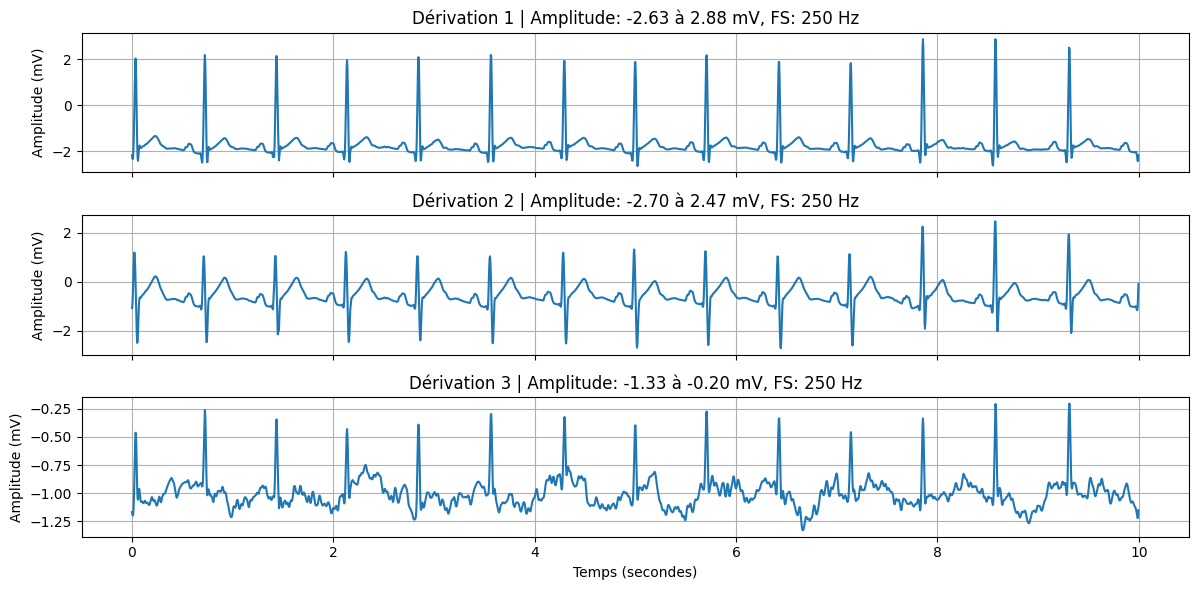

In [9]:
# Paramètres de l'ECG 2D
num_leads, num_samples_per_lead = ecg_segment2.shape  # Nombre de dérivations et échantillons par dérivation
sampling_frequency = 250  # Fréquence d'échantillonnage en Hz
target_length = sampling_frequency * 10  # Longueur cible pour 10 secondes de données

# Facteur pour réduire l'amplitude
amplitude_factor = 3  # Ajustez si nécessaire

# Choisir un point de départ aléatoire pour toutes les dérivations
start_index = random.randint(0, num_samples_per_lead - target_length)

# Créer une figure pour les sous-graphiques
fig, axes = plt.subplots(num_leads, 1, figsize=(12, num_leads * 2), sharex=True)  # Partage des axes temporels

for lead in range(num_leads):
    # Extraire le même segment de 10 secondes pour chaque dérivation et réduire l'amplitude
    lead_signal = ecg_segment2[lead, start_index:start_index + target_length] * amplitude_factor
    
    # Créer un axe du temps pour l'affichage
    time_axis = np.arange(target_length) / sampling_frequency  # Temps en secondes

    # Tracer la dérivation dans un sous-graphe distinct
    axes[lead].plot(time_axis, lead_signal)
    amplitude_min = np.min(lead_signal)
    amplitude_max = np.max(lead_signal)

    # Définir les titres et étiquettes
    axes[lead].set_title(f"Dérivation {lead + 1} | Amplitude: {amplitude_min:.2f} à {amplitude_max:.2f} mV, FS: {sampling_frequency} Hz")
    axes[lead].set_ylabel("Amplitude (mV)")
    axes[lead].grid()

# Étiquettes générales
axes[-1].set_xlabel("Temps (secondes)")
plt.tight_layout()
plt.show()


In [10]:
# Assurer que beatpos est un tableau 1D pour les calculs
if beatpos.ndim > 1:
    beatpos = beatpos[0]  # Sélectionne la première ligne si beatpos est 2D

# Affichage des informations corrigées
print(f"Première valeur de beatpos : {beatpos[0]}")
print(f"Dernière valeur de beatpos : {beatpos[-1]}")
print(f"Nombre total de battements : {len(beatpos)}")

# Calcul de la durée totale à partir des battements de beatpos
try:
    duration_hours = (beatpos[-1] - beatpos[0]) / 250 / 3600
    print(f"Durée totale estimée à partir de beatpos : {duration_hours:.2f} heures")
except TypeError as e:
    print(f"Erreur dans le calcul de la durée : {e}")

Première valeur de beatpos : 0.436
Dernière valeur de beatpos : 51751.517
Nombre total de battements : 67464
Durée totale estimée à partir de beatpos : 0.06 heures


Durée totale de l'ECG affichée sur le tachogramme : 862.54 minutes


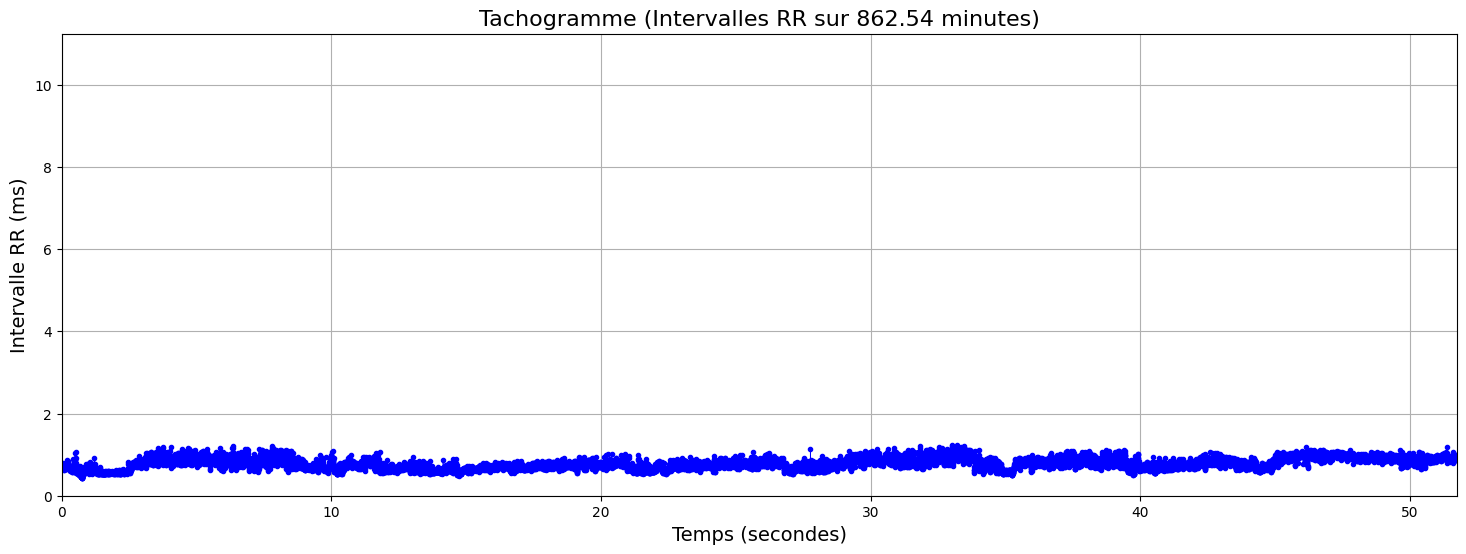

In [11]:
def plot_tachogram(beatpos, sampling_rate, ecg_data_duration, sample_step=10):
    # Convertir beatpos en 1D si nécessaire
    if beatpos.ndim > 1 and beatpos.shape[0] == 1:
        beatpos = beatpos.flatten()  # Convertir en une liste 1D
    
    # Calcul des intervalles RR en millisecondes
    rr_intervals = np.diff(beatpos)  # beatpos est déjà en millisecondes
    time_axis = beatpos[1:] / 1000  # Temps en secondes pour l'axe x

    # Calcul de la durée totale d'affichage des données ECG
    display_duration = ecg_data_duration / sampling_rate  # Durée en secondes
    print(f"Durée totale de l'ECG affichée sur le tachogramme : {display_duration / 60:.2f} minutes")
    
    # Limiter les données au display_duration
    end_time = min(display_duration, time_axis[-1])  # Limite de temps en secondes
    mask = time_axis <= end_time
    limited_time_axis = time_axis[mask][::sample_step]  # Sous-échantillonnage pour espacer les points
    limited_rr_intervals = rr_intervals[mask][::sample_step]  # Sous-échantillonnage des intervalles RR

    # Tracer le tachogramme avec une échelle étendue et un style ajusté
    plt.figure(figsize=(18, 6))  # Ajuster la largeur pour une meilleure visibilité
    plt.plot(limited_time_axis, limited_rr_intervals, marker='o', markersize=3, linestyle='-', linewidth=0.5, color='b')
    
    # Ajuster les limites de l'axe pour correspondre à la durée d'affichage choisie
    plt.xlim(0, end_time)  # Limiter l'axe des x à la durée d'affichage
    plt.ylim(0, max(limited_rr_intervals) + 10)  # Ajuster l'échelle y pour afficher les RR intervals correctement
    plt.title(f"Tachogramme (Intervalles RR sur {display_duration/60:.2f} minutes)", fontsize=16)
    plt.xlabel("Temps (secondes)", fontsize=14)
    plt.ylabel("Intervalle RR (ms)", fontsize=14)
    plt.grid()
    plt.show()

# Exemple d'appel sans besoin de spécifier display_duration manuellement
# Assurez-vous de bien définir `ecg_data` avant d'exécuter l'appel
ecg_data_duration = ecg_data.shape[1]  # Nombre total d'échantillons dans ecg_data
plot_tachogram(beatpos, sampling_rate=250, ecg_data_duration=ecg_data_duration, sample_step=5)


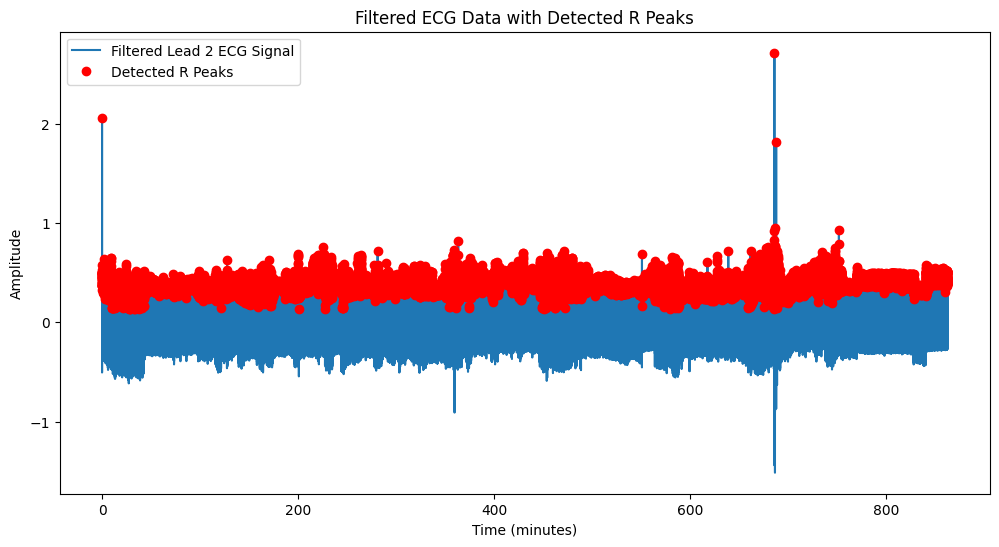

In [12]:
def bandpass_filter(signal, lowcut=0.5, highcut=30, fs=250, order=4):
    """
    Apply a bandpass filter to the signal to isolate the frequency range of interest for R peaks.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Step 1: Apply a narrower bandpass filter to the entire ECG signal (using Lead 2 as example)
fs = 250  # Sampling frequency
filtered_ecg_data = bandpass_filter(ecg_data[1], lowcut=0.5, highcut=30, fs=fs)  # Assuming lead 2 is used

# Step 2: Detect R peaks with stricter criteria
height_threshold = np.mean(filtered_ecg_data) + 1.5 * np.std(filtered_ecg_data)  # Adjusted threshold
distance_samples = int(0.6 * fs)  # Minimum distance of 0.6 seconds between peaks

# Find peaks in the filtered signal
r_peaks, _ = find_peaks(filtered_ecg_data, height=height_threshold, distance=distance_samples)

# Convert x-axis to time in minutes
time_axis = np.arange(len(filtered_ecg_data)) / fs / 60  # Converts sample index to time in minutes

# Step 3: Visualize the filtered ECG data with detected R peaks
plt.figure(figsize=(12, 6))
plt.plot(time_axis, filtered_ecg_data, label="Filtered Lead 2 ECG Signal")
plt.plot(time_axis[r_peaks], filtered_ecg_data[r_peaks], 'ro', label="Detected R Peaks")  # Points instead of crosses
plt.title("Filtered ECG Data with Detected R Peaks")
plt.xlabel("Time (minutes)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()



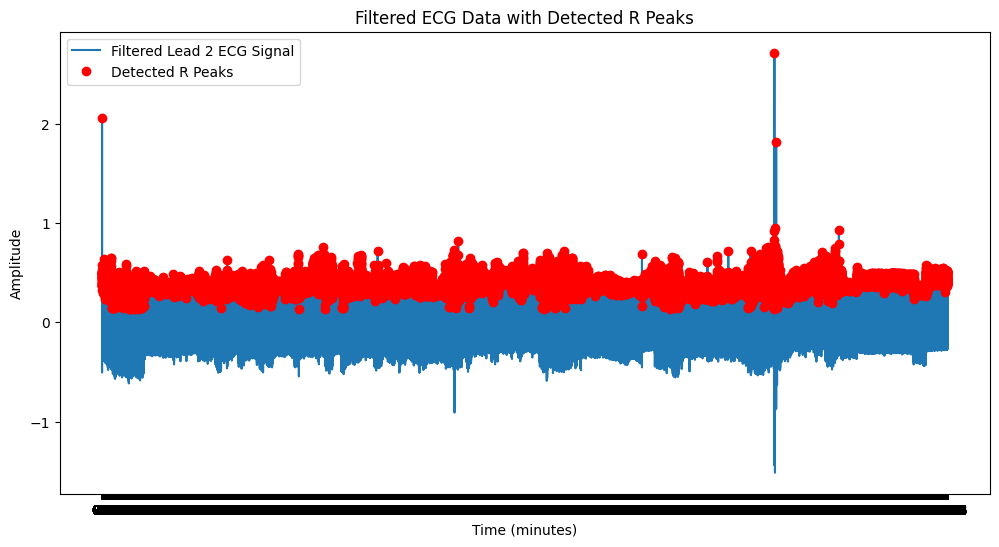

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import mplcursors


def bandpass_filter(signal, lowcut=0.5, highcut=30, fs=250, order=4):
    """
    Apply a bandpass filter to the signal to isolate the frequency range of interest for R peaks.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Step 1: Filter the ECG data
fs = 250  # Sampling frequency
filtered_ecg_data = bandpass_filter(ecg_data[1], lowcut=0.5, highcut=30, fs=fs)

# Step 2: Detect R peaks
height_threshold = np.mean(filtered_ecg_data) + 1.5 * np.std(filtered_ecg_data)
distance_samples = int(0.6 * fs)
r_peaks, _ = find_peaks(filtered_ecg_data, height=height_threshold, distance=distance_samples)

# Convert x-axis to time in minutes
time_axis = np.arange(len(filtered_ecg_data)) / fs / 60  # Convert sample index to time in minutes

# Step 3: Plot with increased width and custom x-axis tick interval
fig, ax = plt.subplots(figsize=(12, 6))  # Increased width for a wider plot

# Plot the ECG signal and detected R peaks
ax.plot(time_axis, filtered_ecg_data, label="Filtered Lead 2 ECG Signal")
ax.plot(time_axis[r_peaks], filtered_ecg_data[r_peaks], 'ro', label="Detected R Peaks")  # Use points

# Customize x-axis ticks
ax.set_xticks(np.arange(0, time_axis[-1], step=100 / fs / 60))  # Tick interval of 100 samples in time (minutes)

# Labels, title, and legend
ax.set_title("Filtered ECG Data with Detected R Peaks")
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Amplitude")
ax.legend()

# Enable interactive cursor for hovering data points
mplcursors.cursor(hover=True)

plt.show()



In [14]:
# import numpy as np
# import plotly.graph_objs as go
# from scipy.signal import find_peaks, butter, filtfilt

# def bandpass_filter(signal, lowcut=0.5, highcut=30, fs=250, order=4):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype="band")
#     return filtfilt(b, a, signal)

# # Step 1: Filter the ECG data
# fs = 250  # Sampling frequency
# filtered_ecg_data = bandpass_filter(ecg_data[1], lowcut=0.5, highcut=30, fs=fs)

# # Step 2: Detect R peaks
# height_threshold = np.mean(filtered_ecg_data) + 1.5 * np.std(filtered_ecg_data)
# distance_samples = int(0.6 * fs)
# r_peaks, _ = find_peaks(filtered_ecg_data, height=height_threshold, distance=distance_samples)

# # Convert x-axis to time in minutes
# time_axis = np.arange(len(filtered_ecg_data)) / fs / 60  # Convert sample index to time in minutes

# # Step 3: Create the Plotly figure
# trace_ecg = go.Scatter(x=time_axis, y=filtered_ecg_data, mode='lines', name='Filtered ECG Signal')
# trace_peaks = go.Scatter(x=time_axis[r_peaks], y=filtered_ecg_data[r_peaks], mode='markers', 
#                          marker=dict(color='red', size=6), name='Detected R Peaks')

# layout = go.Layout(
#     title="Filtered ECG Data with Detected R Peaks",
#     xaxis=dict(title="Time (minutes)"),
#     yaxis=dict(title="Amplitude"),
# )

# fig = go.Figure(data=[trace_ecg, trace_peaks], layout=layout)
# fig.show()


Nombre de battements détectés (points dans beatpos) : 46828
Durée totale des données ECG : 0.04 heures


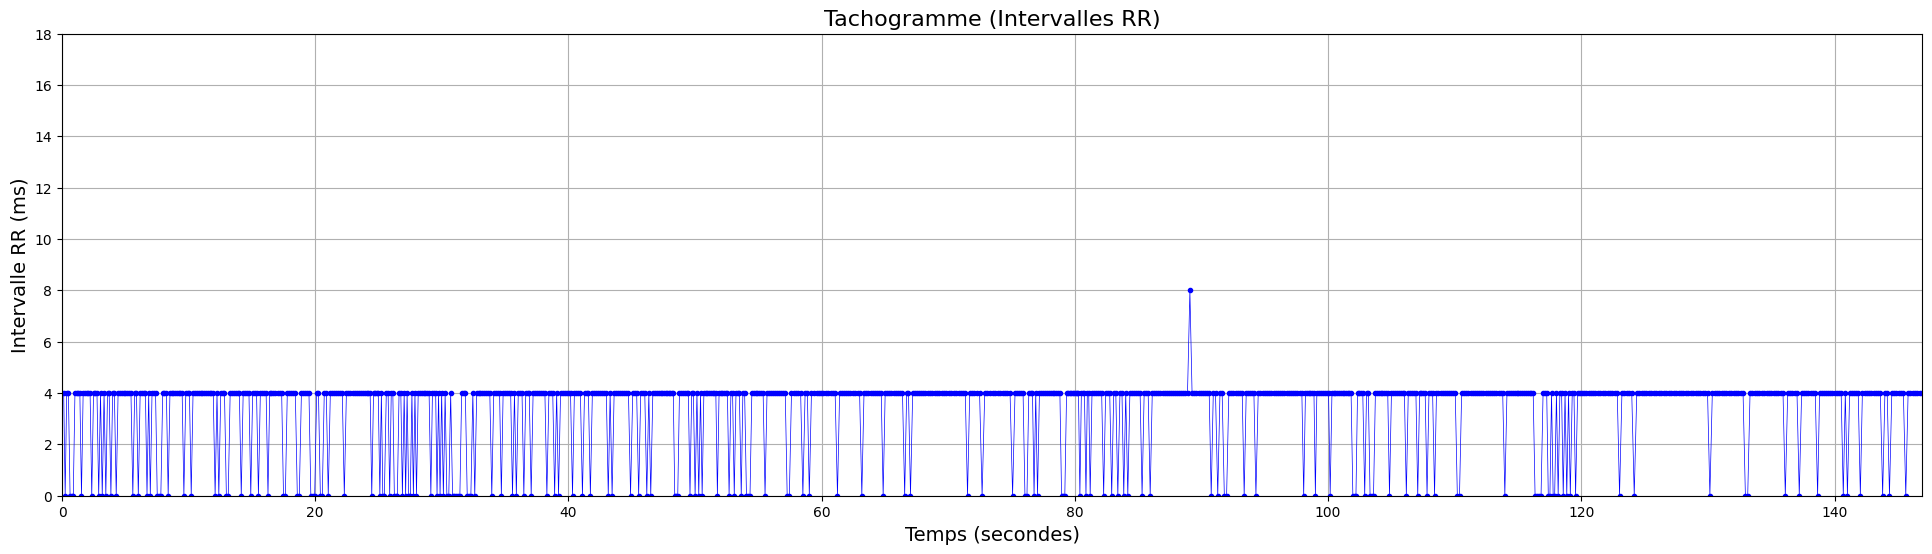

In [15]:
def plot_tachogram(beatpos_segment, sampling_rate, sample_step=10):
    # Vérification de la structure de beatpos
    if beatpos_segment.ndim > 1 and beatpos_segment.shape[0] == 1:
        beatpos_segment = beatpos_segment.flatten()  # Convertir en une liste 1D si nécessaire
    
    # Vérifier la longueur de beatpos
    print(f"Nombre de battements détectés (points dans beatpos) : {len(beatpos_segment)}")
    if len(beatpos_segment) <= 1:
        print("Pas assez de données pour calculer les intervalles RR.")
        return

    # Calcul des intervalles RR en millisecondes
    rr_intervals = np.diff(beatpos_segment) / sampling_rate * 1000  # Conversion en ms
    time_axis = beatpos_segment[1:] / sampling_rate  # Temps en secondes, sans le premier point

    # Vérification de la durée totale des données ECG
    total_duration = time_axis[-1] / 3600  # Convertir en heures pour plus de clarté
    print(f"Durée totale des données ECG : {total_duration:.2f} heures")

    # Sous-échantillonnage pour augmenter l'espacement entre les points
    time_axis_sampled = time_axis[::sample_step]
    rr_intervals_sampled = rr_intervals[::sample_step]

    # Tracer le tachogramme avec des paramètres ajustés pour une meilleure visibilité
    plt.figure(figsize=(24, 6))  # Augmenter encore la largeur pour étirer le graphique
    plt.plot(time_axis_sampled, rr_intervals_sampled, marker='o', markersize=3, linestyle='-', linewidth=0.5, color='b')
    
    # Ajuster l'échelle des axes pour afficher toutes les données
    plt.xlim(0, max(time_axis_sampled))  # Afficher toute la durée sur l'axe des x
    plt.ylim(0, max(rr_intervals_sampled) + 10)  # Ajuste la limite supérieure de y
    plt.title("Tachogramme (Intervalles RR)", fontsize=16)
    plt.xlabel("Temps (secondes)", fontsize=14)
    plt.ylabel("Intervalle RR (ms)", fontsize=14)
    plt.grid()
    plt.show()

# Exemple d'appel avec beatpos et une fréquence d'échantillonnage de 250 Hz
# Ajustez sample_step pour augmenter ou réduire l'espacement entre les points
plot_tachogram(beatpos_segment, sampling_rate=250, sample_step=50)


   RMSSD (ms)  Mean RR (ms)   SDNN (ms)  Mean HR (bpm)  STD HR (bpm)  \
0   38.408297    767.103168  130.268441      78.216337     13.696284   

   Min HR (bpm)  Max HR (bpm)  NN50 (count)  PNN50 (%)  LF Power (ms²)  \
0     43.235453    234.604106          9316  13.809256     1003.670391   

   HF Power (ms²)  LF/HF Ratio  Total Power (ms²)  PNS Index (%)  \
0     1613.003313     0.622237        4454.549933      36.210242   

   SNS Index (%)  RR Triangular Index  Stress Index   SD1 (ms)   SD2 (ms)  \
0      22.531353             59.59629     11.503456  27.158767  182.21453   

   SD2/SD1 Ratio  
0       6.709234  


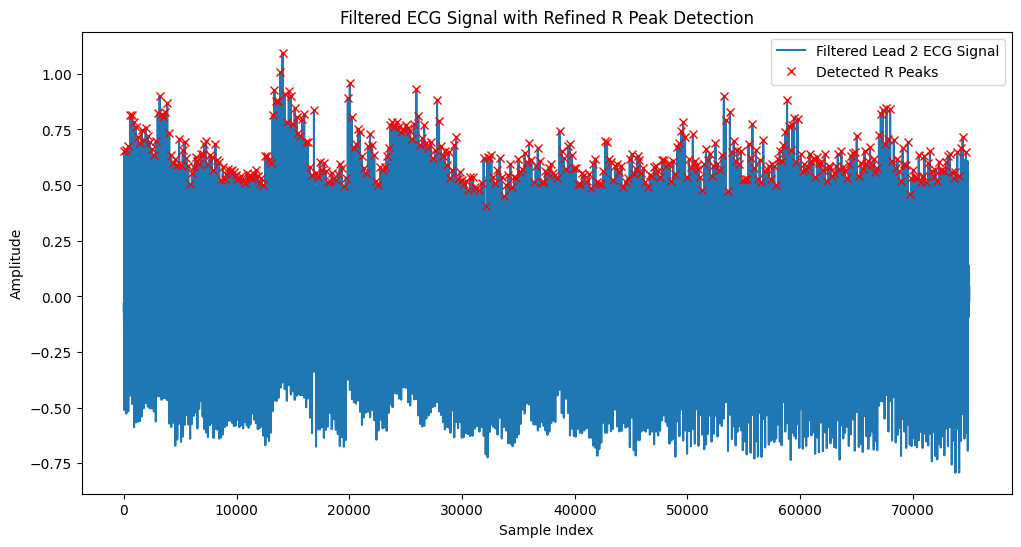

In [16]:
def calculate_vfc_metrics(rr_intervals, fs=4):
    """
    Calcul des métriques VFC avec unités : RMSSD, Mean RR, SDNN, Mean HR, STD HR, 
    Min HR, Max HR, NN50, PNN50, LF Power, HF Power, LF/HF Ratio, Total Power, etc.

    Parameters:
    - rr_intervals: Array des intervalles RR en millisecondes.
    - fs: Fréquence d'échantillonnage pour l'analyse spectrale (par défaut 4 Hz).
    
    Returns:
    - metrics: Dictionnaire contenant les différentes métriques VFC.
    """
    rr_intervals = np.array(rr_intervals)
    N = len(rr_intervals)
    diff_rr = np.diff(rr_intervals)

    # Time Domain Metrics
    rmssd = np.sqrt(np.mean(diff_rr**2))                      # Unité : ms
    mean_rr = np.mean(rr_intervals)                           # Unité : ms
    sdnn = np.std(rr_intervals)                               # Unité : ms
    mean_hr = 60 / (mean_rr / 1000)                           # Unité : bpm
    std_hr = np.std(60 / (rr_intervals / 1000))               # Unité : bpm
    min_hr = 60 / (np.max(rr_intervals) / 1000)              # Unité : bpm
    max_hr = 60 / (np.min(rr_intervals) / 1000)              # Unité : bpm
    nn50 = np.sum(np.abs(diff_rr) > 50)                       # Unité : nombre
    pnn50 = (nn50 / (N - 1)) * 100                            # Unité : %

    # Frequency Domain Metrics using Welch's Method (in ms²)
    rr_intervals_centered = rr_intervals - np.mean(rr_intervals)
    freqs, psd = welch(rr_intervals_centered, fs=fs, nperseg=min(256, len(rr_intervals_centered)))
    lf_band = (freqs >= 0.04) & (freqs <= 0.15)
    hf_band = (freqs >= 0.15) & (freqs <= 0.4)
    lf_power = np.trapz(psd[lf_band], freqs[lf_band])         # Unité : ms²
    hf_power = np.trapz(psd[hf_band], freqs[hf_band])         # Unité : ms²
    total_power = np.trapz(psd[freqs > 0], freqs[freqs > 0])  # Unité : ms²

    # Additional Metrics
    lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan
    pns_index = (hf_power / total_power) * 100 if total_power != 0 else np.nan
    sns_index = (lf_power / total_power) * 100 if total_power != 0 else np.nan
    rr_triangular_index = N / np.ptp(rr_intervals)            # Unité : sans unité
    stress_index = (sdnn**2) / (rmssd**2) if rmssd != 0 else np.nan
    sd1 = np.sqrt(np.var(diff_rr) / 2)                        # Unité : ms
    sd2 = np.sqrt(2 * sdnn**2 - sd1**2)                       # Unité : ms
    sd2_sd1_ratio = sd2 / sd1 if sd1 != 0 else np.nan

    metrics = {
        'RMSSD (ms)': rmssd,
        'Mean RR (ms)': mean_rr,
        'SDNN (ms)': sdnn,
        'Mean HR (bpm)': mean_hr,
        'STD HR (bpm)': std_hr,
        'Min HR (bpm)': min_hr,
        'Max HR (bpm)': max_hr,
        'NN50 (count)': nn50,
        'PNN50 (%)': pnn50,
        'LF Power (ms²)': lf_power,
        'HF Power (ms²)': hf_power,
        'LF/HF Ratio': lf_hf_ratio,
        'Total Power (ms²)': total_power,
        'PNS Index (%)': pns_index,
        'SNS Index (%)': sns_index,
        'RR Triangular Index': rr_triangular_index,
        'Stress Index': stress_index,
        'SD1 (ms)': sd1,
        'SD2 (ms)': sd2,
        'SD2/SD1 Ratio': sd2_sd1_ratio
    }

    return metrics

# Exemple d'utilisation
sampling_rate = 250  # Fréquence d'échantillonnage (par exemple 250 Hz)
rr_intervals = np.diff(beatpos) * 1000  # Conversion en ms

metrics = calculate_vfc_metrics(rr_intervals)
df_metrics = pd.DataFrame([metrics])
print(df_metrics)

from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt

def bandpass_filter(signal, lowcut=0.5, highcut=30, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Step 1: Apply a narrower bandpass filter to the signal
ecg_filtered = bandpass_filter(ecg_segment2[1], lowcut=0.5, highcut=30, fs=250)  # Assuming lead 2 is used
fs=250
# Step 2: Detect R peaks with stricter criteria
height_threshold = np.mean(ecg_filtered) + 1.5 * np.std(ecg_filtered)  # Increased threshold factor
distance_samples = int(0.6 * fs)  # Minimum distance of 0.6 seconds between peaks

peaks, _ = find_peaks(ecg_filtered, height=height_threshold, distance=distance_samples)

# Step 3: Visualize the filtered ECG signal with detected R peaks
plt.figure(figsize=(12, 6))
plt.plot(ecg_filtered, label="Filtered Lead 2 ECG Signal")
plt.plot(peaks, ecg_filtered[peaks], 'rx', label="Detected R Peaks")
plt.title("Filtered ECG Signal with Refined R Peak Detection")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


   RMSSD (ms)  Mean RR (ms)  SDNN (ms)  Mean HR (bpm)  STD HR (bpm)  \
0   53.366309    692.203233  60.824476      86.679745      6.396655   

   Min HR (bpm)  Max HR (bpm)  NN50 (count)  PNN50 (%)  LF Power (ms²)  \
0      49.50495     99.337748            11   2.546296      216.668997   

   HF Power (ms²)  LF/HF Ratio  Total Power (ms²)  PNS Index (%)  \
0      968.011685     0.223829        1791.725686      54.026779   

   SNS Index (%)  RR Triangular Index  Stress Index   SD1 (ms)  SD2 (ms)  \
0      12.092755             0.712171       1.29904  37.731575  77.30176   

   SD2/SD1 Ratio  
0       2.048729  


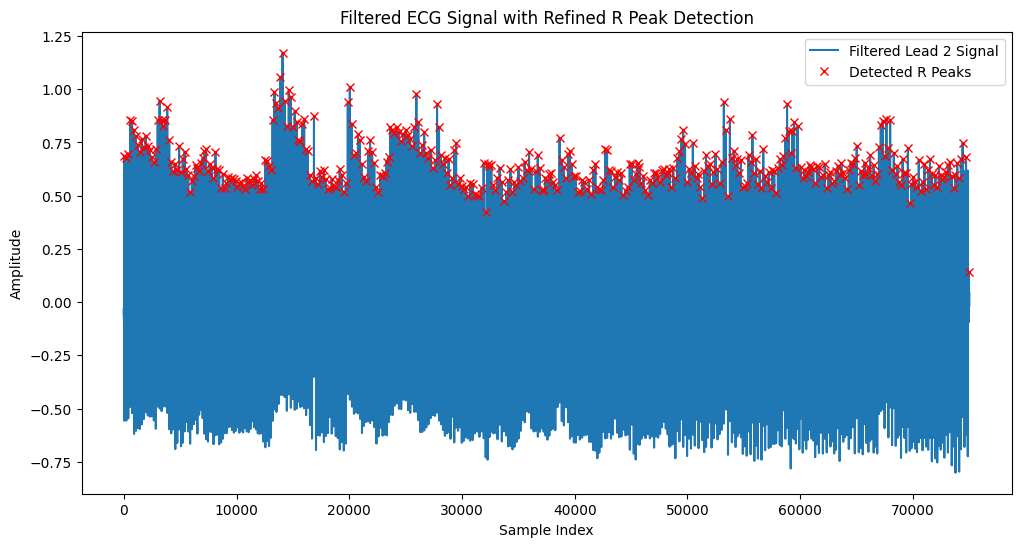

In [17]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# Step 1: Filter the signal
ecg_filtered = bandpass_filter(ecg_segment2[1], lowcut=0.5, highcut=40, fs=250)  # Assuming lead 2 is used

# Step 2: Detect R peaks with stricter criteria
height_threshold = np.mean(ecg_filtered) + 0.5 * np.std(ecg_filtered)  # Adjust this factor if needed
distance_samples = int(0.6 * fs)  # Minimum distance of 0.6 seconds between peaks

peaks, _ = find_peaks(ecg_filtered, height=height_threshold, distance=distance_samples)

# Convert detected R peaks into RR intervals (in milliseconds)
rr_intervals2 = np.diff(peaks) * (1000 / 250)  # Convert intervals to ms (assuming fs = 250 Hz)

# Filter out implausibly short RR intervals (e.g., less than 300 ms)
rr_intervals_filtered2 = rr_intervals2[rr_intervals2 > 300]

# Calculate HRV metrics using the filtered RR intervals
metrics2 = calculate_vfc_metrics(rr_intervals_filtered2)
df_metrics2 = pd.DataFrame([metrics2])
print(df_metrics2)

# Step 3: Plot the filtered signal with detected R peaks
plt.figure(figsize=(12, 6))
plt.plot(ecg_filtered, label="Filtered Lead 2 Signal")
plt.plot(peaks, ecg_filtered[peaks], "rx", label="Detected R Peaks")
plt.title("Filtered ECG Signal with Refined R Peak Detection")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [18]:
def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal - np.mean(signal))
    snr = 10 * np.log10(signal_power / noise_power)
    return min(max(snr, 0), 100)

def detect_motion_artifacts(signal, threshold=0.5):
    motion_artifacts = np.sum(np.abs(np.diff(signal)) > threshold)
    artifact_score = 100 - (motion_artifacts / len(signal) * 100)
    return max(artifact_score, 0)

def calculate_saturation_index(signal, saturation_level=1.0):
    saturation_points = np.sum(np.abs(signal) >= saturation_level)
    saturation_score = 100 - (saturation_points / len(signal) * 100)
    return max(saturation_score, 0)

def calculate_baseline_stability(signal):
    baseline_variation = np.std(signal)
    stability_score = 100 - min(baseline_variation, 100)
    return max(stability_score, 0)

def calculate_waveform_consistency(signal):
    segment_length = len(signal) // 10
    correlation_scores = []
    for i in range(1, 10):
        correlation = np.corrcoef(signal[:segment_length], signal[i * segment_length:(i + 1) * segment_length])[0, 1]
        correlation_scores.append(correlation)
    avg_consistency = np.mean(correlation_scores) * 100
    return max(min(avg_consistency, 100), 0)

def calculate_rr_variability(rr_intervals):
    rr_std = np.std(rr_intervals)
    variability_score = 100 - min(rr_std, 100)
    return max(variability_score, 0)

def calculate_sqi(snr, artifacts, saturation, baseline_stability, waveform_consistency, rr_variability):
    return np.mean([snr, artifacts, saturation, baseline_stability, waveform_consistency, rr_variability])

def quality_score_lead(signal, rr_intervals):
    snr = calculate_snr(signal)
    artifacts = detect_motion_artifacts(signal)
    saturation = calculate_saturation_index(signal)
    baseline_stability = calculate_baseline_stability(signal)
    waveform_consistency = calculate_waveform_consistency(signal)
    rr_variability = calculate_rr_variability(rr_intervals)
    
    sqi = calculate_sqi(snr, artifacts, saturation, baseline_stability, waveform_consistency, rr_variability)
    
    weights = {
        'snr': 0.25,
        'artifacts': 0.15,
        'saturation': 0.15,
        'baseline_stability': 0.15,
        'waveform_consistency': 0.1,
        'rr_variability': 0.1,
        'sqi': 0.1
    }
    
    score = (
        snr * weights['snr'] +
        artifacts * weights['artifacts'] +
        saturation * weights['saturation'] +
        baseline_stability * weights['baseline_stability'] +
        waveform_consistency * weights['waveform_consistency'] +
        rr_variability * weights['rr_variability'] +
        sqi * weights['sqi']
    )
    
    # Combine lead score and lead SQI
    combined_quality_score = (score + sqi) / 2  # Combine with equal weight for now
    
    return round(score, 2), round(sqi, 2), round(combined_quality_score, 2)

def calculate_overall_quality(ecg_segment2, rr_intervals):
    lead_scores = []
    lead_sqis = []
    lead_combined_scores = []
    
    for lead_idx in range(ecg_segment2.shape[0]):
        lead_signal = ecg_segment2[lead_idx, :]
        lead_score, lead_sqi, lead_combined_score = quality_score_lead(lead_signal, rr_intervals)
        lead_scores.append(lead_score)
        lead_sqis.append(lead_sqi)
        lead_combined_scores.append(lead_combined_score)
    
    # Calculer la qualité globale du signal
    overall_quality = np.mean(lead_scores)
    overall_sqi = np.mean(lead_sqis)
    overall_combined_score = np.mean(lead_combined_scores)
    
    return lead_scores, lead_sqis, lead_combined_scores, round(overall_quality, 2), round(overall_sqi, 2), round(overall_combined_score, 2)

# Exemple d'utilisation avec des intervalles RR simulés
sampling_rate = 250  # Fréquence d'échantillonnage en Hz

# Calculer les scores de qualité pour chaque dérivation et le signal global
lead_scores, lead_sqis, lead_combined_scores, overall_quality, overall_sqi, overall_combined_score = calculate_overall_quality(ecg_segment2, rr_intervals) + 20

print("Scores de qualité pour chaque dérivation :", lead_scores)
print("SQI pour chaque dérivation :", lead_sqis)
print("Score combiné pour chaque dérivation :", lead_combined_scores)
print("Qualité globale du signal :", overall_quality)
print("SQI global du signal :", overall_sqi)
print("Score de qualité global combiné :", overall_combined_score)


# Calcul des scores de qualité pour chaque dérivation et pour le signal global
lead_scores, lead_sqis, lead_combined_scores, overall_quality, overall_sqi, overall_combined_score = calculate_overall_quality(ecg_segment2, rr_intervals)

# Qualité du meilleur lead : sélectionner le score combiné le plus élevé parmi les dérivations
best_lead_quality = max(lead_combined_scores)

# Ajouter la qualité du meilleur lead et la qualité globale du signal dans df_metrics
df_metrics['Qualité Meilleur Lead'] = best_lead_quality
df_metrics['Qualité Globale Signal'] = overall_combined_score

# Affichage des résultats finaux
print("Qualité du meilleur lead :", best_lead_quality)


Scores de qualité pour chaque dérivation : [52.41, 50.91, 53.83]
SQI pour chaque dérivation : [51.5, 50.56, 52.49]
Score combiné pour chaque dérivation : [51.95, 50.73, 53.16]
Qualité globale du signal : 52.38
SQI global du signal : 51.52
Score de qualité global combiné : 51.95
Qualité du meilleur lead : 53.16


In [19]:
# Fonction pour ajuster les seuils en fonction des caractéristiques individuelles
def ajuster_seuils(seuils, sexe, imc, activite_physique, age):
    # Ajustement selon le sexe
    if sexe == 'F':
        seuils['mean_hr_brady'] += 5
        seuils['mean_hr_tachy'] -= 5
    elif sexe == 'M':
        seuils['mean_hr_brady'] -= 5
        seuils['mean_hr_tachy'] += 5

    # Ajustement selon l'IMC
    if imc < 18.5:
        seuils['sdnn'] -= 5
        seuils['rmssd'] -= 5
    elif imc >= 25:
        seuils['sdnn'] += 5
        seuils['rmssd'] += 5

    # Ajustement selon l'activité physique
    if activite_physique == 'élevée':
        seuils['mean_hr_brady'] -= 5
        seuils['lf_hf_ratio_max'] += 0.5
    elif activite_physique == 'modérée':
        seuils['mean_hr_brady'] -= 2
        seuils['lf_hf_ratio_max'] += 0.2
    elif activite_physique == 'sédentaire':
        seuils['mean_hr_brady'] += 5
        seuils['mean_hr_tachy'] -= 5
        seuils['lf_hf_ratio_min'] += 0.1

    # Ajustement selon l'âge
    if age < 30:
        seuils['mean_hr_brady'] -= 3
        seuils['sdnn'] += 5
    elif 30 <= age < 60:
        seuils['mean_hr_brady'] += 2
        seuils['mean_hr_tachy'] -= 2
    elif age >= 60:
        seuils['mean_hr_brady'] += 5
        seuils['mean_hr_tachy'] -= 5
        seuils['sdnn'] -= 5

    return seuils

# Fonction pour étiqueter les patients selon des anomalies spécifiques avec niveaux de gravité
def etiquetage_patient(metrics, sexe, poids, taille, activite_physique, age):
    imc = poids / (taille / 100)**2

    seuils = {
        'rmssd': 20,
        'sdnn': 30,
        'mean_hr_brady': 50,
        'mean_hr_tachy': 100,
        'stress_index': 10,
        'lf_hf_ratio_min': 0.5,
        'lf_hf_ratio_max': 2.0,
        'nac_sdnn': 20,
        'nac_rmssd': 15
    }

    seuils = ajuster_seuils(seuils, sexe, imc, activite_physique, age)
    
    anomalies_legere = []
    anomalies_moderee = []
    anomalies_severe = []
    
    # Bradycardie
    if metrics['Mean HR (bpm)'] < seuils['mean_hr_brady']:
        if metrics['Mean HR (bpm)'] < seuils['mean_hr_brady'] - 10:
            anomalies_severe.append("Bradycardie sévère")
        elif metrics['Mean HR (bpm)'] < seuils['mean_hr_brady'] - 5:
            anomalies_moderee.append("Bradycardie modérée")
        else:
            anomalies_legere.append("Bradycardie légère")
    
    # Tachycardie
    if metrics['Mean HR (bpm)'] > seuils['mean_hr_tachy']:
        if metrics['Mean HR (bpm)'] > seuils['mean_hr_tachy'] + 10:
            anomalies_severe.append("Tachycardie sévère")
        elif metrics['Mean HR (bpm)'] > seuils['mean_hr_tachy'] + 5:
            anomalies_moderee.append("Tachycardie modérée")
        else:
            anomalies_legere.append("Tachycardie légère")
            
    # Fibrillation auriculaire
    if metrics['SDNN (ms)'] < seuils['sdnn'] and metrics['RMSSD (ms)'] < seuils['rmssd']:
        if metrics['SDNN (ms)'] < seuils['sdnn'] / 2 and metrics['RMSSD (ms)'] < seuils['rmssd'] / 2:
            anomalies_severe.append("Fibrillation auriculaire sévère")
        elif metrics['SDNN (ms)'] < seuils['sdnn'] - 10 and metrics['RMSSD (ms)'] < seuils['rmssd'] - 10:
            anomalies_moderee.append("Fibrillation auriculaire modérée")
        else:
            anomalies_legere.append("Fibrillation auriculaire légère")
    
    # Neuropathie cardiaque autonome
    if metrics['SDNN (ms)'] < seuils['nac_sdnn'] and metrics['RMSSD (ms)'] < seuils['nac_rmssd']:
        if metrics['SDNN (ms)'] < seuils['nac_sdnn'] / 2 and metrics['RMSSD (ms)'] < seuils['nac_rmssd'] / 2:
            anomalies_severe.append("Neuropathie cardiaque autonome sévère")
        elif metrics['SDNN (ms)'] < seuils['nac_sdnn'] - 5 and metrics['RMSSD (ms)'] < seuils['nac_rmssd'] - 5:
            anomalies_moderee.append("Neuropathie cardiaque autonome modérée")
        else:
            anomalies_legere.append("Neuropathie cardiaque autonome légère")
    
    # Syndrome de stress
    if metrics['Stress Index'] > seuils['stress_index']:
        if metrics['Stress Index'] > seuils['stress_index'] * 1.5:
            anomalies_severe.append("Syndrome de stress sévère")
        elif metrics['Stress Index'] > seuils['stress_index'] * 1.2:
            anomalies_moderee.append("Syndrome de stress modéré")
        else:
            anomalies_legere.append("Syndrome de stress léger")

    # Déséquilibre parasympathique/sympathique
    if metrics['LF/HF Ratio'] < seuils['lf_hf_ratio_min']:
        anomalies_legere.append("LF/HF Ratio bas (déséquilibre parasympathique)")
    elif metrics['LF/HF Ratio'] > seuils['lf_hf_ratio_max']:
        anomalies_legere.append("LF/HF Ratio élevé (déséquilibre sympathique)")

    if anomalies_severe:
        return 'Anormal', anomalies_severe + anomalies_moderee + anomalies_legere
    elif anomalies_moderee:
        return 'Anormal', anomalies_moderee + anomalies_legere
    elif anomalies_legere:
        return 'Borderline', anomalies_legere
    else:
        return 'Normal', []

# Processus pour étiqueter les résultats des métriques calculées avec les caractéristiques individuelles du patient
def etiquetage_ecg_vfc(vfc_metrics_df, sexe, poids, taille, activite_physique, age):
    etiquetage_results = {'État': [], 'Anomalies Détectées': []}

    for idx, metrics in vfc_metrics_df.iterrows():
        etat, anomalies = etiquetage_patient(metrics, sexe, poids, taille, activite_physique, age)
        etiquetage_results['État'].append(etat)
        etiquetage_results['Anomalies Détectées'].append(anomalies)
    
    return pd.DataFrame(etiquetage_results)

# Exemple d'utilisation

sexe = 'H'
poids = 80
taille = 186
activite_physique = 'élevée'
age = 24

etiquetage_results_df = etiquetage_ecg_vfc(df_metrics, sexe, poids, taille, activite_physique, age)

# Ajout des colonnes "État" et "Anomalies Détectées" au DataFrame des métriques
df_metrics['État'] = etiquetage_results_df['État']
df_metrics['Anomalies Détectées'] = etiquetage_results_df['Anomalies Détectées']

# Affichage des résultats finaux
print(df_metrics.head())

print("_"*80)

etiquetage_results_df2 = etiquetage_ecg_vfc(df_metrics2, sexe, poids, taille, activite_physique, age)

# Ajout des colonnes "État" et "Anomalies Détectées" au DataFrame des métriques
df_metrics2['État'] = etiquetage_results_df2['État']
df_metrics2['Anomalies Détectées'] = etiquetage_results_df2['Anomalies Détectées']

# Affichage des résultats finaux
print(df_metrics2.head())


   RMSSD (ms)  Mean RR (ms)   SDNN (ms)  Mean HR (bpm)  STD HR (bpm)  \
0   38.408297    767.103168  130.268441      78.216337     13.696284   

   Min HR (bpm)  Max HR (bpm)  NN50 (count)  PNN50 (%)  LF Power (ms²)  ...  \
0     43.235453    234.604106          9316  13.809256     1003.670391  ...   

   SNS Index (%)  RR Triangular Index  Stress Index   SD1 (ms)   SD2 (ms)  \
0      22.531353             59.59629     11.503456  27.158767  182.21453   

   SD2/SD1 Ratio  Qualité Meilleur Lead  Qualité Globale Signal        État  \
0       6.709234                  53.16                   51.95  Borderline   

          Anomalies Détectées  
0  [Syndrome de stress léger]  

[1 rows x 24 columns]
________________________________________________________________________________
   RMSSD (ms)  Mean RR (ms)  SDNN (ms)  Mean HR (bpm)  STD HR (bpm)  \
0   53.366309    692.203233  60.824476      86.679745      6.396655   

   Min HR (bpm)  Max HR (bpm)  NN50 (count)  PNN50 (%)  LF Power (ms²) 

In [20]:
print(df_metrics['État'])
print(df_metrics['Anomalies Détectées'])

0    Borderline
Name: État, dtype: object
0    [Syndrome de stress léger]
Name: Anomalies Détectées, dtype: object


In [21]:
print(df_metrics2['État'])
print(df_metrics2['Anomalies Détectées'])

0    Borderline
Name: État, dtype: object
0    [LF/HF Ratio bas (déséquilibre parasympathique)]
Name: Anomalies Détectées, dtype: object


In [3]:
!jupyter nbconvert --to script "C:/Users/marwa/OneDrive/Documents/Final/final.ipynb"

[NbConvertApp] Converting notebook C:/Users/marwa/OneDrive/Documents/Final/final.ipynb to script
[NbConvertApp] Writing 40697 bytes to C:\Users\marwa\OneDrive\Documents\Final\final.py
